<a href="https://colab.research.google.com/github/trdunsworth/eda2/blob/main/VA_NENA_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy scipy matplotlib seaborn scikit-learn plotly statsmodels pretty_errors

In [ ]:
%matplotlib inline

import os
import sys
import numbers
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import datetime as dt
import pandas as pd
import numpy as np
from scipy import stats as ss
from scipy.stats import normaltest as norm
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
import pretty_errors

In [ ]:
pretty_errors.configure(
    separator_character="*",
    line_number_first=1,
    display_link=1,
    line_color=pretty_errors.BRIGHT_RED
    + "> "
    + pretty_errors.default_config.line_color,
    exception_color=pretty_errors.BRIGHT_MAGENTA,
    exception_arg_color=pretty_errors.CYAN,
    exception_file_color=pretty_errors.RED_BACKGROUND + pretty_errors.BRIGHT_WHITE,
    code_color="  " + pretty_errors.default_config.line_color,
    display_timestamp=1,
    timestamp_function=lambda: datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    lines_before=5,
    lines_after=2,
    stack_depth=1,
    display_locals=1,  # Enable the display of local variables
    line_length=80
)

In [ ]:
"""
This code sets display and formatting parameters for the notebook
For example: floats, numbers with a decimal point, will only show 2 values behind the decimal
There is a column wrap at 80 characters and this will only display 8 columns of multicolumn output
"""
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.width', 80)
pd.set_option('display.max_columns', 12)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/synthetic_date/synth.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Response_Date     10000 non-null  object
 1   Week No           10000 non-null  int64 
 2   Hour              10000 non-null  int64 
 3   Day               10000 non-null  int64 
 4   DOW               10000 non-null  object
 5   Agency            10000 non-null  object
 6   Problem           10000 non-null  object
 7   Priority_Number   10000 non-null  int64 
 8   Call_Reception    10000 non-null  object
 9   Call_Disposition  10000 non-null  object
 10  TimeToQueue       10000 non-null  int64 
 11  TimeToDispatch    10000 non-null  int64 
 12  CallProcessTime   10000 non-null  int64 
 13  PhoneTime         10000 non-null  int64 
 14  EventTime         10000 non-null  int64 
dtypes: int64(9), object(6)
memory usage: 1.1+ MB


In [ ]:
df.head().T

,0,1,2,3,4
Response_Date,1/14/2024 00:51,1/14/2024 00:53,1/14/2024 00:53,1/14/2024 00:53,1/14/2024 00:53
Week No,3,3,3,3,3
Hour,0,0,0,0,0
Day,14,14,14,14,14
DOW,SUN,SUN,SUN,SUN,SUN
Agency,POLICE,POLICE,POLICE,POLICE,POLICE
Problem,TROUBLE UNKNOWN NO EMS,DOMESTIC VIOL NO INJ,DISORDERLY CONDUCT,_RARE_,SUSPICIOUS EVENT
Priority_Number,2,2,2,2,2
Call_Reception,E-911,E-911,E-911,E-911,Phone
Call_Disposition,NR-No Report,NR-No Report,RE-Report,RE-Report,NR-No Report


In [ ]:
df = df.rename(columns={'Week No': 'WeekNo'})

In [ ]:
"""
I'm using this code to change some of the int64 columns
into objects because they are ordinal values
and I do not need to have them treated the same as
continuous numeric variables.
"""
df['Day'] = df['Day'].astype('object')
df['Hour'] = df['Hour'].astype('object')
df['WeekNo'] = df['WeekNo'].astype('object')
df['Priority_Number'] = df['Priority_Number'].astype('category')

df['Response_Date'] = pd.to_datetime(df['Response_Date'], dayfirst=True)

<ipython-input-9-056bc9966c5c>:11: UserWarning: Parsing dates in %m/%d/%Y %H:%M format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Response_Date'] = pd.to_datetime(df['Response_Date'], dayfirst=True)


In [ ]:
"""
Now I use this code to convert the object Dtype into a category Dtype
This will be easier for creating good visuals later.
"""
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')

In [ ]:
df.describe()

,Response_Date,Priority_Number,TimeToQueue,TimeToDispatch,CallProcessTime,PhoneTime,EventTime
count,10000,"10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00"
mean,2024-03-03 01:40:45.462000128,2.53,596.20,897.76,"1,493.96",311.33,"6,894.00"
min,2024-01-14 00:51:00,1.00,0.00,1.00,2.00,0.00,5.00
25%,2024-02-11 11:53:00,2.00,33.00,29.00,97.00,100.00,"1,329.25"
50%,2024-03-10 12:47:00,2.00,66.00,94.00,203.00,177.00,"3,079.00"
75%,2024-04-14 16:12:30,3.00,124.00,323.25,477.25,327.00,"7,849.00"
max,2024-04-20 23:38:00,10.00,"100,685.00","84,173.00","176,583.00","6,121.00","143,560.00"
std,NaN,1.21,"5,420.25","5,024.65","8,056.77",509.99,"12,031.28"


In [12]:
df['Priority_Number'] = df['Priority_Number'].astype('category')

In [13]:
df_int = df[['TimeToQueue','TimeToDispatch','CallProcessTime','PhoneTime','EventTime']]

In [14]:
df_int.describe()

,TimeToQueue,TimeToDispatch,CallProcessTime,PhoneTime,EventTime
count,"10,000.00","10,000.00","10,000.00","10,000.00","10,000.00"
mean,596.20,897.76,"1,493.96",311.33,"6,894.00"
std,"5,420.25","5,024.65","8,056.77",509.99,"12,031.28"
min,0.00,1.00,2.00,0.00,5.00
25%,33.00,29.00,97.00,100.00,"1,329.25"
50%,66.00,94.00,203.00,177.00,"3,079.00"
75%,124.00,323.25,477.25,327.00,"7,849.00"
max,"100,685.00","84,173.00","176,583.00","6,121.00","143,560.00"


In [15]:
for column in df_int.columns:
    skew_col = round(df_int[column].skew(), 2)
    kurt_col = round(df_int[column].kurtosis(), 2)
    if skew_col < 0 and kurt_col > 3:
        print(f"{column}: skewness = {skew_col}, kurtosis = {kurt_col}\n {column} is left-tailed and leptokurtic.\n")
    elif skew_col < 0 and kurt_col == 3:
        print(f"{column}: skewness = {skew_col}, kurtosis = {kurt_col}\n {column} is left-tailed and mesokurtic.\n")
    elif skew_col < 0 and kurt_col < 3:
        print(f"{column}: skewness = {skew_col}, kurtosis = {kurt_col}\n {column} is left-tailed and platykurtic.\n")
    elif skew_col > 0 and kurt_col > 3:
        print(f"{column}: skewness = {skew_col}, kurtosis = {kurt_col}\n {column} is right-tailed and leptokurtic.\n")
    elif skew_col > 0 and kurt_col == 3:
        print(f"{column}: skewness = {skew_col}, kurtosis = {kurt_col}\n {column} is right-tailed and mesokurtic.\n")
    elif skew_col > 0 and kurt_col < 3:
        print(f"{column}: skewness = {skew_col}, kurtosis = {kurt_col}\n {column} is right-tailed and platykurtic.\n")
    elif skew_col == 0 and kurt_col > 3:
        print(f"{column}: skewness = {skew_col}, kurtosis = {kurt_col}\n {column} is symmetrical and leptokurtic.\n")
    elif skew_col == 0 and kurt_col < 3:
        print(f"{column}: skewness = {skew_col}, kurtosis = {kurt_col}\n {column} is symmetrical and platykurtic.\n")
    else:
        print(f"{column}: skewness = {skew_col}, kurtosis = {kurt_col}\n {column} is Gaussian.\n")

TimeToQueue: skewness = 14.04, kurtosis = 213.02
 TimeToQueue is right-tailed and leptokurtic.

TimeToDispatch: skewness = 11.85, kurtosis = 156.7
 TimeToDispatch is right-tailed and leptokurtic.

CallProcessTime: skewness = 11.01, kurtosis = 143.61
 CallProcessTime is right-tailed and leptokurtic.

PhoneTime: skewness = 5.87, kurtosis = 46.14
 PhoneTime is right-tailed and leptokurtic.

EventTime: skewness = 6.02, kurtosis = 50.91
 EventTime is right-tailed and leptokurtic.



In [16]:
def test_normalcy(df, column):
    print(f"{column}:\n")
    qqplot(df[column], line='s')
    plt.show()

    stat, p = ss.kstest(df[column], 'norm')
    print('Statistics = %.3f, p = %.3f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)\n')

TimeToQueue:



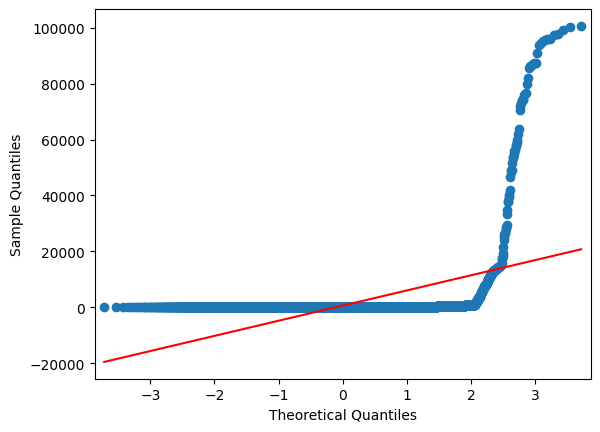

Statistics = 0.952, p = 0.000
Sample does not look Gaussian (reject H0)



In [17]:
test_normalcy(df, 'TimeToQueue')

TimeToDispatch:



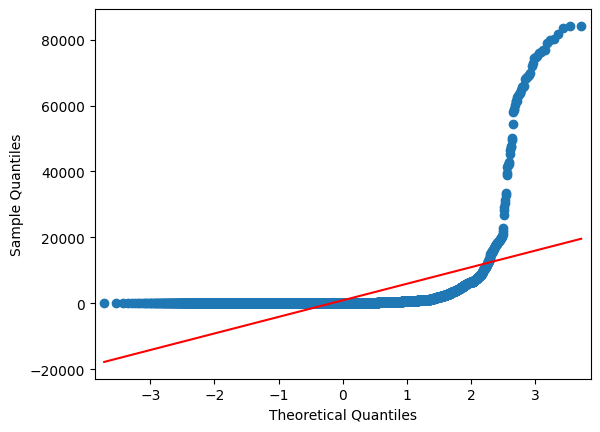

Statistics = 0.974, p = 0.000
Sample does not look Gaussian (reject H0)



In [18]:
test_normalcy(df, 'TimeToDispatch')

CallProcessTime:



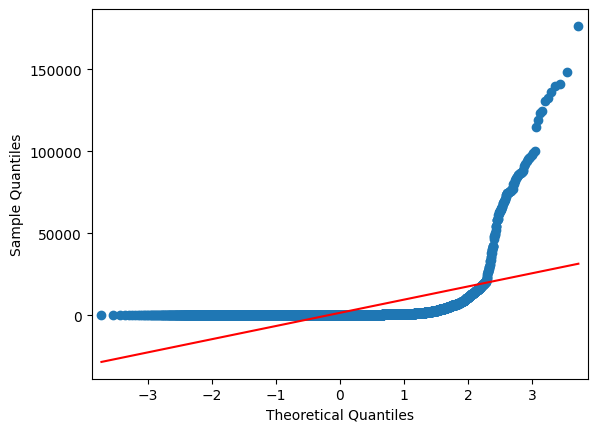

Statistics = 0.998, p = 0.000
Sample does not look Gaussian (reject H0)



In [19]:
test_normalcy(df, 'CallProcessTime')

PhoneTime:



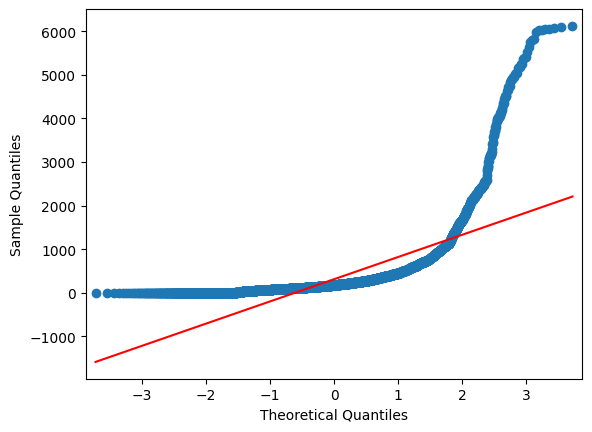

Statistics = 0.938, p = 0.000
Sample does not look Gaussian (reject H0)



In [20]:
test_normalcy(df, 'PhoneTime')

EventTime:



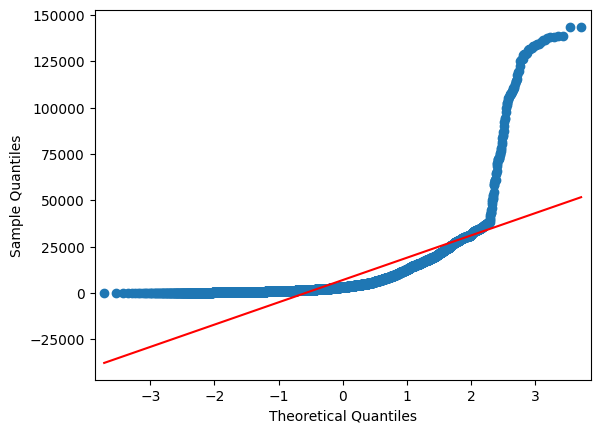

Statistics = 1.000, p = 0.000
Sample does not look Gaussian (reject H0)



In [21]:
test_normalcy(df, 'EventTime')

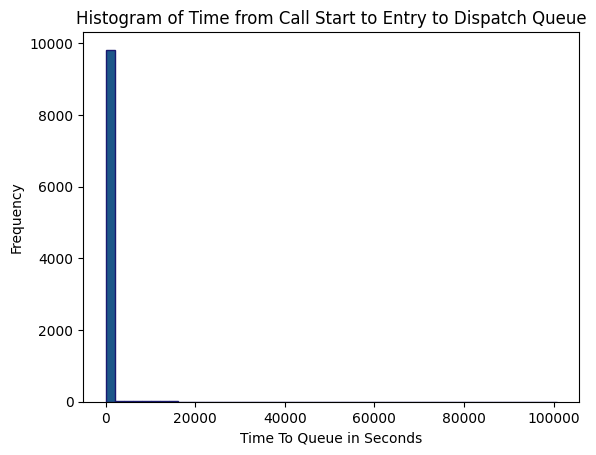

In [24]:
plt.hist(df['TimeToQueue'], bins=50, color="#1C5789", edgecolor='midnightblue')
plt.xlabel('Time To Queue in Seconds')
plt.ylabel('Frequency')
plt.title('Histogram of Time from Call Start to Entry to Dispatch Queue')
plt.show()

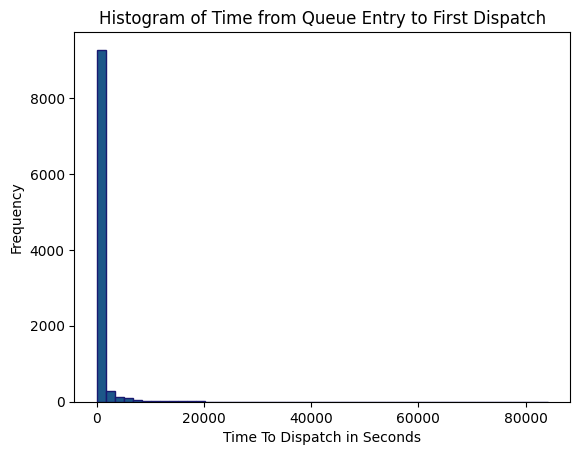

In [25]:
plt.hist(df['TimeToDispatch'], bins=50, color="#1C5789", edgecolor='midnightblue')
plt.xlabel('Time To Dispatch in Seconds')
plt.ylabel('Frequency')
plt.title('Histogram of Time from Queue Entry to First Dispatch')
plt.show()

[Text(0, 0, '1464'),
 Text(0, 0, '1455'),
 Text(0, 0, '1236'),
 Text(0, 0, '1461'),
 Text(0, 0, '1531'),
 Text(0, 0, '1370'),
 Text(0, 0, '1483')]

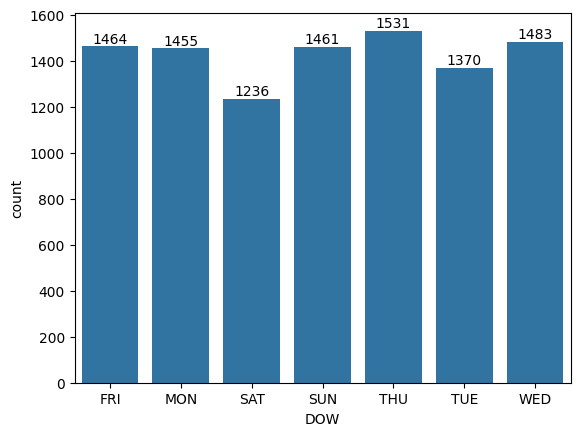

In [26]:
"""
From this point, we can now separate the data multiple ways to drill into the most interesting points.
There will be a lot of code to do that.
There will also be a section for visualization because, a picture is worth a thousand words.
"""
ax = sns.countplot(x='DOW', data=df)
ax.bar_label(ax.containers[0])

[Text(0, 0, '1055'), Text(0, 0, '494'), Text(0, 0, '8451')]

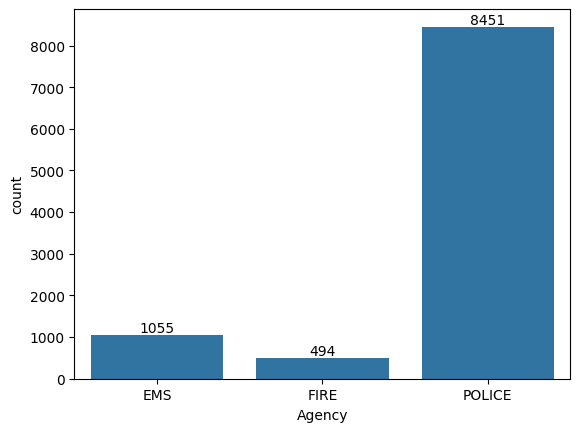

In [27]:
"""
From this point, we can now separate the data multiple ways to drill into the most interesting points.
There will be a lot of code to do that.
There will also be a section for visualization because, a picture is worth a thousand words.
"""
ax = sns.countplot(x='Agency', data=df)
ax.bar_label(ax.containers[0])